# 103.7. How to create a large cutout from deep_coadd images

<div style="max-width:300px; float: left; margin-right: 1em">

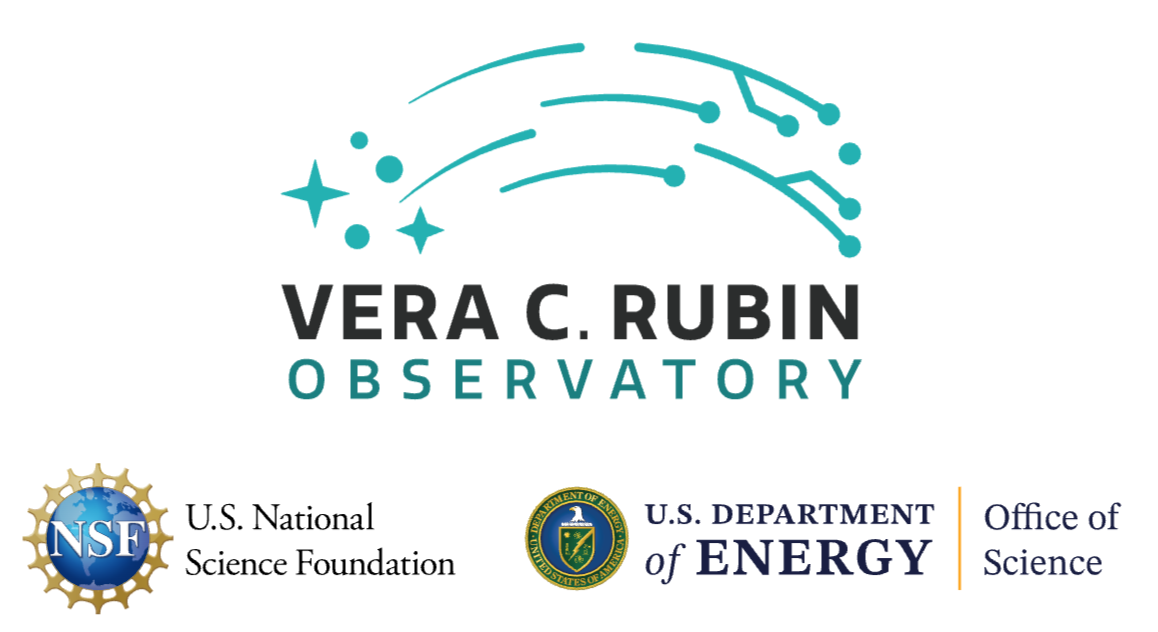

</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.2.0 <br>
Last verified to run: 2025-10-21 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** Create a large custom `deep_coadd` cutout.

**LSST data products:** `deep_coadd`.

**Packages:** `lsst.daf.butler`, `lsst.ip.diffim.GetTemplateTask`.

**Credit:** Originally developed by Andrés A. Plazas Malagón and the Rubin Community Science team with input from Nate Lust.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This tutorial demonstrates how to create a large, custom cutout from the LSST deep coadd images using the Rubin Science Platform (RSP) and the LSST Science Pipelines, defining an arbitrary sky region with the galaxy cluster Abell 360 as an example.
The workflow follows a process similar to template generation in alert production, using `GetTemplateTask` to assemble input exposures into a single image defined by a user-specified World Coordinate System (WCS) and bounding box.

**Related tutorials**: 100-level tutorial to make a color composite image.

### 1.1. Import packages

`GetTemplateTask` (`lsst.ip.diffim`) retrieves template images for image differencing, while `lsst.pipe.tasks.makeDiscreteSkyMap` generates discrete sky maps for defining sky coverage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay

from lsst.geom import Box2I, Point2I, SpherePoint, degrees, Point2D
from lsst.sphgeom import Box as SphBox

from lsst.ip.diffim import GetTemplateTask
from lsst.pipe.tasks.makeDiscreteSkyMap import MakeDiscreteSkyMapTask

### 1.2. Define parameters and functions

Instantiate the butler.

In [2]:
butler = Butler("dp1", collections="LSSTComCam/DP1")
assert butler is not None

Define the skymap.

In [3]:
skymap = butler.get("skyMap")

## 2. Prepare to create the cutout

Use the galaxy cluster Abell 360 (A360), a rich galaxy cluster at redshift 0.22 that is included in the DP1 data release in the `SV_38_7` field.
The angular extent of A360 is larger than a single coadd patch, so creating a large cutout is necessary to capture the full cluster within a single image.

Define the coordinates of the brightest cluster galaxy (BCG), in degrees.

In [4]:
ra_bcg = 37.865
dec_bcg = 6.982

Define a box size of 0.1 degrees around the BCG, then search for all patches within twice that size (2 * `box_size_deg`).

In [5]:
box_size_deg = 0.1

Define the region from where the `deep_coadd` dataset references will be retrieved.

In [6]:
box_region = SphBox.fromDegrees(ra_bcg - box_size_deg, dec_bcg - box_size_deg,
                                ra_bcg + box_size_deg, dec_bcg + box_size_deg)

Get the dataset references in the `r` band.

In [7]:
my_band = ['r']

In [8]:
dataset_refs = set(
    butler.query_datasets(
        "deep_coadd",
        where=f"patch.region OVERLAPS(region) and band in ('{my_band[0]}')",
        bind={"region": box_region}
    )
)

Inspect the references for the `deep_coadd`s, corresponding to different patches in the region.

In [9]:
dataset_refs

{DatasetRef(DatasetType('deep_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'r', skymap: 'lsst_cells_v1', tract: 10463, patch: 61}, run='LSSTComCam/runs/DRP/DP1/DM-51335', id=8aa7f95c-3dbe-476c-85c8-4e2281149c62),
 DatasetRef(DatasetType('deep_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'r', skymap: 'lsst_cells_v1', tract: 10463, patch: 62}, run='LSSTComCam/runs/DRP/DP1/DM-51335', id=c85e7244-2e5a-4243-97b1-003967101a74),
 DatasetRef(DatasetType('deep_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'r', skymap: 'lsst_cells_v1', tract: 10463, patch: 71}, run='LSSTComCam/runs/DRP/DP1/DM-51335', id=0e665dab-7ad3-4541-a79b-8fb57cc5d145),
 DatasetRef(DatasetType('deep_coadd', {band, skymap, tract, patch}, ExposureF), {band: 'r', skymap: 'lsst_cells_v1', tract: 10463, patch: 72}, run='LSSTComCam/runs/DRP/DP1/DM-51335', id=61911c12-3d76-497b-8312-d07c3c9360b4)}

## 3. Create the cutout

Create an image of an arbitrary sky region that is not aligned with the native Legacy Survey of Space and Time (LSST) sky tessellation.
This is similar to the process in alert production, where past LSST observations are combined to generate static-sky templates for detecting transients in new exposures.
The same template-generation code (`GetTemplateTask`) can be used to transform input data aligned on the LSST tessellation into the required geometry.

To use the template code, a single astrometric solution or World Coordinate System (WCS) that encompasses all input data is needed, instead of having a separate tangent-plane WCS for each tract.
A new and custom discrete skymap is therefore created for the input data, producing one tract with a single WCS projection.
A bounding box is then defined in these new coordinates, centered on the brightest cluster galaxy (BCG) and spanning the specified width.

With this setup, images are generated per band by combining the inputs that fall within the bounding box. The `GetTemplateTask` creates coadds for each band.

Prepare the inputs for building the custom skymap.

For each dataset reference, the WCS and bounding box of its patch are stored, so the collection of positions can later define the custom skymap that includes only the data in use.
At the same time, the dataset references are organized into a nested dictionary: first grouped by band, then within each band grouped by tract.
Each tract key contains all the dataset refs for that tract band combination.

In [10]:
position_container = []
sorted_data = {}
for ds_ref in dataset_refs:
    did = ds_ref.dataId

    patchInfo = skymap[did["tract"]][did["patch"]]
    position_container.append((patchInfo.wcs, patchInfo.outer_bbox))

    band_container = sorted_data.setdefault(did["band"], dict())
    tract_container = band_container.setdefault(did["tract"], list())
    tract_container.append(ds_ref)

Make a skymap that contains all input data.

In [11]:
discrete_skymap_config = MakeDiscreteSkyMapTask().ConfigClass()

The default configuration values of this custom skymap for the pixel scale and WCS projection type are not appropriate for LSSTComCam.
The following cells override these parameters with appropriate values.

Use the BCG location to obtain the pixel scale there.
First, get the WCS of the patch and tract where the BCG is located.

In [13]:
bcg_point = SpherePoint(ra_bcg * degrees,
                        dec_bcg * degrees)
bcg_tract = skymap.findTract(bcg_point)
bcg_patch = bcg_tract.findPatch(bcg_point)

bcg_tract_number = bcg_tract.tract_id
bcg_patch_number = bcg_patch.getSequentialIndex()
print(bcg_tract_number, bcg_patch_number)

10463 61


Get the data reference for the coadd in the `r` band that contains the BCG.

In [19]:
bcg_data_ref = next(
    ref
    for ref in sorted_data[my_band[0]][bcg_tract_number]
    if ref.dataId["patch"] == bcg_patch_number
)

Get the coadd from the data reference.

In [20]:
bcg_coadd = butler.get(bcg_data_ref)

Get the WCS from the coadd.

In [21]:
wcs_bcg = bcg_coadd.getWcs()

In [22]:
bcg_point = SpherePoint(ra_bcg * degrees,
                        dec_bcg * degrees)

Use the plate scale at the BCG location.

In [23]:
plate_scale_bcg = wcs_bcg.getPixelScale(Point2D(bcg_point)).asArcseconds()

Set the plate scale in the new skymap.

In [24]:
discrete_skymap_config.skyMap.pixelScale = plate_scale_bcg

Set the WCS projection type.
The WCS of `deep_coadd` images are `TAN` projections ([see the DP1 documentation](https://dp1.lsst.io/products/images/deep_coadd.html#wcs)).

In [25]:
discrete_skymap_config.skyMap.projection = 'TAN'

Compute the new skymap.

In [26]:
new_skymap = MakeDiscreteSkyMapTask(config=discrete_skymap_config).run(position_container).skyMap

Get the new WCS from the single tract discrete skymap.

In [27]:
new_wcs = new_skymap[0].wcs

In [28]:
new_wcs

FITS standard SkyWcs:
Sky Origin: (37.8481271152, +7.0272990684)
Pixel Origin: (5999, 5999)
Pixel Scale: 0.199937 arcsec/pixel

Create a bounding box in the new WCS coordinates that is centered on the BCG and has the width defined above.

In [29]:
small_box = Box2I(
    Point2I(new_wcs.skyToPixel(SpherePoint(ra_bcg - box_size_deg,
                                           dec_bcg - box_size_deg, degrees))),
    Point2I(new_wcs.skyToPixel(SpherePoint(ra_bcg + box_size_deg,
                                           dec_bcg + box_size_deg, degrees))),
)

Create a new coadd image in the band defined above (`r`) that is a combination of the inputs contained within the defined box.
Note that the run method modifies the bounding box in place, so a copy is made.

In [30]:
getTemplateTask = GetTemplateTask()
mapping = sorted_data[my_band[0]]

small_box_copy = Box2I(small_box)
new_image_r = getTemplateTask.run(
    coaddExposures={
        tract: [butler.get(ref) for ref in refs] for tract, refs in mapping.items()
    },
    bbox=small_box_copy,
    wcs=new_wcs,
    dataIds={tract: [ref.dataId for ref in refs] for tract, refs in mapping.items()},
    physical_filter=my_band[0],
)

## 4. Visualize the custom cutout

### 4.1 Diplay with Matplotlib

In [31]:
afwDisplay.setDefaultBackend('matplotlib')

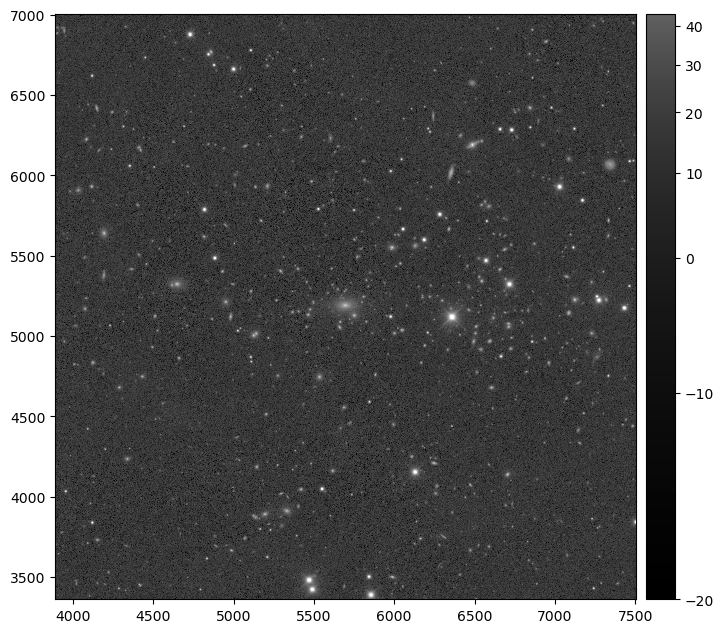

In [32]:
fig = plt.figure(figsize=(8, 8))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(new_image_r.template.image)
plt.show()

> Figure 1: Cutout of the Abell 360 cluster, displayed using `matplotlib` as backend for `awf.display`. Note that the coordinates are in pixel units.

In [33]:
new_image_r.template.image.array.shape

(3642, 3615)

### 4.2. Display with Firefly

Firefly allows for interactive image display and manipulation.

Reset the `afwDisplay` backend to be Firefly and start the display.
A new tab will open, containing the Firefly interface.
Note that Firelfly will use the new WCS information to display the image in celestial coordinates.

In [34]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.Display(frame=1)

Display the image in Firefly.

In [35]:
afw_display.mtv(new_image_r.template)

The Firefly default is to visualize the mask plane with colors. 
Set the mask plane transparency to 100, fully transparent, to see only the pixel data.

In [36]:
afw_display.setMaskTransparency(100)

### 4.3. Option to save as a FITS file

To save as a FITS file in the home directory, uncomment (remove the #)
from all lines in the following cell and then execute it.

> **Warning:** Images can take up a lot of disk space. Save and download with caution.

In [37]:
# username = os.environ.get('USER')
# fnm = '/home/' + username + '/my_big_cutout_dp1_a360.fits'
# new_image_r.template.writeFits(fnm)
# del username, fnm

## 5. Compare PSFs

Retrieve the Point Spread Function (PSF) objects for the new big coadd and for the coadd associated with the cluster BCG. 
Compare the PSF size at the location of the BCG and at near one corner of the big coadd region.

Define the locations.

In [38]:
margin = 0.01
locations = [
    ("center", bcg_point),
    ("corner", SpherePoint(ra_bcg - box_size_deg + margin,
                           dec_bcg - box_size_deg + margin, degrees)),
]

Loop over locations and compare the PSF Full Width at Half Maximum (FWHM) size for each one.

In [39]:
SIGMA_TO_FWHM = 2.0*np.sqrt(2.0*np.log(2.0))
for label, loc in locations:
    center_pix_coadd = wcs_bcg.skyToPixel(loc)
    point_coadd = Point2D(center_pix_coadd)
    coadd_psf = bcg_coadd.getPsf()
    psf_sigma_coadd = coadd_psf.computeShape(point_coadd).getDeterminantRadius()

    center_pix_new = new_wcs.skyToPixel(loc)
    point_new = Point2D(center_pix_new)
    newimage_psf = new_image_r.template.getPsf()
    psf_sigma_new = newimage_psf.computeShape(point_new).getDeterminantRadius()

    percent_diff = np.abs(psf_sigma_coadd - psf_sigma_new) / psf_sigma_new * 100
    print(f"{label} coadd_bcg FWHM = {psf_sigma_coadd * SIGMA_TO_FWHM: .3f} pixels")
    print(f"{label} newimage FWHM = {psf_sigma_new * SIGMA_TO_FWHM: .3f} pixels")
    print(f"{label} percent difference = {percent_diff: .2f}%\n")

center coadd_bcg FWHM =  5.515 pixels
center newimage FWHM =  5.513 pixels
center percent difference =  0.03%

corner coadd_bcg FWHM =  5.455 pixels
corner newimage FWHM =  5.444 pixels
corner percent difference =  0.20%

